<a href="https://colab.research.google.com/github/cgN77/invsto_task/blob/main/Invstotask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from typing import List, Dict, Tuple

In [2]:
symbols = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'WMT'
        ]
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
data = None
signals = None
portfolio = None
performance = None
portfolio_value = 1_000_000
initial_capital = 1_000_000
volatility_lookback = 60
signal_lookback = 20
risk_free_rate = 0.02
min_volatility_threshold = 0.0001
min_signal_threshold = 0.001
n_splits = 5
commission_rate = 0.001
slippage = 0.0005
min_position_change = 0.05
current_positions = None

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from typing import List, Dict, Tuple


def collect_data() -> Dict:
    """Collect historical data for all symbols"""
    print("Collecting historical data...")
    data_dict={}

    for symbol in symbols:
        try:
            ticker=yf.Ticker(symbol)
            df=ticker.history(start=start_date, end=end_date)
            data_dict[symbol]=df
            print(f"Collected data for {symbol}")
        except Exception as e:
            print(f"Error collecting data for {symbol}: {str(e)}")
    return data_dict


def calculate_rsi(data, window=14):
    delta=data['Close'].diff().dropna()
    up, down=delta.copy(), delta.copy()
    up[up < 0]=0
    down[down > 0]=0
    roll_up=up.rolling(window).mean()
    roll_down=down.rolling(window).mean().abs()
    RS=roll_up / roll_down
    RSI=100.0 - (100.0 / (1.0 + RS))
    return RSI


def calculate_macd(data, slow=26, fast=12):
    ema_slow=data['Close'].ewm(span=slow, adjust=False).mean()
    ema_fast=data['Close'].ewm(span=fast, adjust=False).mean()
    macd=ema_fast - ema_slow
    signal=macd.ewm(span=9, adjust=False).mean()
    return macd, signal


def calculate_risk_adjusted_returns(returns: pd.Series, window: int=60) -> pd.Series:
    """Calculate risk-adjusted returns using rolling Sharpe ratio with minimum volatility threshold"""
    rolling_returns=returns.rolling(window=window, min_periods=1).mean().shift(1)
    rolling_vol=returns.rolling(window=window, min_periods=1).std().shift(1)

    #replace zero or very low volatility with NaN
    rolling_vol=rolling_vol.replace(0, np.nan)
    rolling_vol=rolling_vol.mask(rolling_vol < min_volatility_threshold, np.nan)

    daily_rf=(1 + risk_free_rate) ** (1/252) - 1
    sharpe_ratio=(rolling_returns - daily_rf) / rolling_vol

    #fill NaN values with 0
    return sharpe_ratio.fillna(0)


def calculate_dynamic_weights(date: datetime) -> Tuple[float, float, float]:
    """Calculate dynamic weights for signal combination based on recent performance"""
    momentum_weight=0.4
    mean_reversion_weight=0.3
    risk_adjusted_weight=0.3

    #recent performance of each signal (last 20 days)
    lookback=20
    for symbol, df in data.items():
        if date in df.index:
            current_idx=df.index.get_loc(date)
            if current_idx >= lookback:
                #returns for the lookback period
                returns=df['Close'].pct_change().shift(1)

                #signal performance
                momentum_perf=returns.rolling(window=signal_lookback, min_periods=1).mean().shift(1)
                momentum_perf=momentum_perf.iloc[current_idx-lookback:current_idx].mean()

                #mean reversion performance
                ma50=df['Close'].rolling(window=50, min_periods=1).mean().shift(1)
                mean_reversion=(df['Close'] - ma50) / ma50
                mean_reversion_perf=mean_reversion.iloc[current_idx-lookback:current_idx].mean()

                #risk-adjusted performance
                risk_adjusted=calculate_risk_adjusted_returns(returns).shift(1)
                risk_adjusted_perf=risk_adjusted.iloc[current_idx-lookback:current_idx].mean()

                #normalize performance scores
                total_perf=abs(momentum_perf) + abs(mean_reversion_perf) + abs(risk_adjusted_perf)
                if total_perf > 0:
                    momentum_weight=abs(momentum_perf) / total_perf
                    mean_reversion_weight=abs(mean_reversion_perf) / total_perf
                    risk_adjusted_weight=abs(risk_adjusted_perf) / total_perf

    return momentum_weight, mean_reversion_weight, risk_adjusted_weight


def generate_signals(data) -> Dict:
    """Generate alpha signals for each stock using dynamic weighting"""
    if data is None:
        raise ValueError("Data not collected. Run collect_data() first.")

    signals_dict={}

    for symbol, df in data.items():
        df=df.copy()
        df.loc[:, 'Returns']=df['Close'].pct_change().shift(1)
        df.loc[:, 'Momentum']=np.nan
        df.loc[:, 'Mean_Reversion']=np.nan
        df.loc[:, 'Risk_Adjusted']=np.nan
        df.loc[:, 'RSI']=np.nan
        df.loc[:, 'MACD']=np.nan
        df.loc[:, 'Combined_Signal']=np.nan
        df.loc[:, 'Momentum']=df['Returns'].rolling(window=signal_lookback,min_periods=1).mean().shift(1)
        ma50=df['Close'].rolling(window=50,min_periods=1).mean().shift(1)
        df.loc[:, 'Mean_Reversion']=(df['Close'] - ma50) / ma50
        df.loc[:, 'Risk_Adjusted']=calculate_risk_adjusted_returns(df['Returns']).shift(1)
        df.loc[:, 'RSI']=calculate_rsi(df)
        macd, signal=calculate_macd(df)
        df.loc[:, 'MACD']=macd
        df=df.ffill()
        for date in df.index:
            momentum_weight, mean_reversion_weight, risk_adjusted_weight=calculate_dynamic_weights(date)
            df.loc[date, 'Combined_Signal']=(
                momentum_weight * df.loc[date, 'Momentum'] +
                mean_reversion_weight * df.loc[date, 'Mean_Reversion'] +
                risk_adjusted_weight * df.loc[date, 'Risk_Adjusted']
            )

        signals_dict[symbol]=df
    return signals_dict


def calculate_position_sizes(date: datetime, positions: Dict) -> Dict:
    """Calculate volatility-adjusted position sizes"""
    position_sizes={'long': {}, 'short': {}}

    #inverse volatility weights for long positions
    long_vols={}
    for symbol in positions['long']:
        if date in signals[symbol].index:
            vol=signals[symbol].loc[:date, 'Returns'].rolling(window=volatility_lookback).std().iloc[-1]
            if vol > 0:  #only include stocks with positive volatility
                long_vols[symbol]=vol
    short_vols={}
    for symbol in positions['short']:
        if date in signals[symbol].index:
            vol=signals[symbol].loc[:date, 'Returns'].rolling(window=volatility_lookback).std().iloc[-1]
            if vol > 0:  #only include stocks with positive volatility
                short_vols[symbol]=vol

    if not long_vols or not short_vols:
        return None

    #normalize weights to sum to 1 for each side
    long_total_inv_vol=sum(1/vol for vol in long_vols.values())
    short_total_inv_vol=sum(1/vol for vol in short_vols.values())

    for symbol in long_vols:
        position_sizes['long'][symbol]=(1/long_vols[symbol]) / long_total_inv_vol

    for symbol in short_vols:
        position_sizes['short'][symbol]=(1/short_vols[symbol]) / short_total_inv_vol

    total_weight=sum(position_sizes['long'].values()) + sum(position_sizes['short'].values())
    if total_weight > 1:
        # Scale down allocations proportionally
        for side in ['long', 'short']:
            for symbol in position_sizes[side]:
                position_sizes[side][symbol] /= total_weight

    return position_sizes

def construct_portfolio(signals):
    """Construct long-short portfolio based on signals with adaptive position sizing and transaction costs"""
    if signals is None:
        raise ValueError("Signals not generated. Run generate_signals() first.")

    portfolio_dict={}
    current_positions=None

    for date in signals[symbols[0]].index:
        #combined signal for each stock
        stock_signals={}
        for symbol, df in signals.items():
            if date in df.index and not pd.isna(df.loc[date, 'Combined_Signal']):
                stock_signals[symbol]=df.loc[date, 'Combined_Signal']

        if len(stock_signals) >= 6:
            ranked_stocks=sorted(stock_signals.items(), key=lambda x: x[1], reverse=True)
            long_stocks=[stock for stock, _ in ranked_stocks[:3]]
            short_stocks=[stock for stock, _ in ranked_stocks[-3:]]

            #new position sizes
            new_positions=calculate_position_sizes(date, {'long': long_stocks, 'short': short_stocks})
            # print(new_positions)
            if new_positions:
                #transaction costs
                transaction_costs=calculate_transaction_costs(current_positions, new_positions, date,signals)

                # Only update positions if transaction costs are reasonable
                if transaction_costs < 0.01:
                    portfolio_dict[date]={
                        'positions': new_positions,
                        'transaction_costs': transaction_costs
                    }
            current_positions=new_positions
    return portfolio_dict

def backtest(portfolio,signals):
    """Backtest the strategy with volatility-adjusted position sizing and transaction costs"""
    if portfolio is None:
        raise ValueError("Portfolio not constructed. Run construct_portfolio() first.")

    returns=[]
    dates=[]
    transaction_costs=[]
    portfolio_values=[initial_capital]
    # print(portfolio.items())
    for date, portfolio_data in portfolio.items():
        # print(portfolio_data)
        daily_return=0
        positions=portfolio_data['positions']
        old_positions=current_positions if 'current_positions' in locals() else None

        #returns with position sizing
        for symbol, weight in positions['long'].items():
            if date in signals[symbol].index:
                daily_return += weight * signals[symbol].loc[:date, 'Returns'].shift(1).iloc[-1]

        for symbol, weight in positions['short'].items():
            if date in signals[symbol].index:
                daily_return -= weight * signals[symbol].loc[:date, 'Returns'].shift(1).iloc[-1]

        transaction_cost=calculate_transaction_costs(old_positions, positions, date,signals)
        daily_return -= transaction_cost / portfolio_values[-1]
        current_value=portfolio_values[-1] * (1 + daily_return)
        portfolio_values.append(current_value)

        returns.append(daily_return)
        dates.append(date)
        transaction_costs.append(transaction_cost)

        current_positions=positions

    if returns:
        performance=pd.Series(returns, index=dates)
        transaction_costs=pd.Series(transaction_costs, index=dates)
        portfolio_value=pd.Series(portfolio_values[1:], index=dates)
    else:
        raise ValueError("No valid returns calculated during backtesting")
    return performance, transaction_costs, portfolio_value


def calculate_transaction_costs(old_positions: Dict, new_positions: Dict, date,signals) -> float:
    """Calculate transaction costs for portfolio rebalancing"""
    if old_positions is None:
        return 0.0
    # print(old_positions)
    total_cost=0.0

    #costs for long positions
    for symbol in set(old_positions['long'].keys()) | set(new_positions['long'].keys()):
        old_weight=old_positions['long'].get(symbol, 0)
        new_weight=new_positions['long'].get(symbol, 0)


        if abs(new_weight - old_weight) >= min_position_change:
            trade_value=abs(new_weight - old_weight) * signals[symbol].loc[date, 'Close']*100
            commission=trade_value * commission_rate
            slippage_cost=trade_value * slippage
            total_cost += commission + slippage_cost

    #costs for short positions
    for symbol in set(old_positions['short'].keys()) | set(new_positions['short'].keys()):
        old_weight=old_positions['short'].get(symbol, 0)
        new_weight=new_positions['short'].get(symbol, 0)


        if abs(new_weight - old_weight) >= min_position_change:
            trade_value=abs(new_weight - old_weight)*signals[symbol].loc[date, 'Close']*100
            commission=trade_value * commission_rate
            slippage_cost=trade_value * slippage
            total_cost += commission + slippage_cost
            # print(f"Symbol: {symbol}, Old Weight: {old_weight}, New Weight: {new_weight}, Trade Value: {trade_value}, Commission: {commission}, Slippage Cost: {slippage_cost}")
    return total_cost


def calculate_metrics(performance,transaction_costs,portfolio_value) -> Dict:
    """Calculate performance metrics with separate long and short drawdowns and transaction costs"""
    if performance is None or len(performance) == 0:
        raise ValueError("Strategy not backtested or no valid returns. Run backtest() first.")

    daily_returns=performance

    cumulative_returns=(1 + daily_returns).cumprod() - 1

    risk_free_rate=0.02
    excess_returns=daily_returns - risk_free_rate/252  # Daily risk-free rate
    sharpe_ratio=np.sqrt(252) * excess_returns.mean() / excess_returns.std() if excess_returns.std() != 0 else 0

    rolling_max=cumulative_returns.expanding().max()
    drawdowns=(cumulative_returns - rolling_max) / rolling_max
    max_drawdown=drawdowns.min() if len(drawdowns) > 0 else 0

    annualized_return=(1 + daily_returns.mean()) ** 252 - 1 if len(daily_returns) > 0 else 0
    annualized_volatility=daily_returns.std() * np.sqrt(252) if len(daily_returns) > 0 else 0

    win_rate=(daily_returns > 0).mean()
    profit_factor=abs(daily_returns[daily_returns > 0].sum() / daily_returns[daily_returns < 0].sum())

    total_transaction_costs=transaction_costs.sum()
    avg_transaction_cost=transaction_costs.mean()
    # transaction_cost_ratio=total_transaction_costs / cumulative_returns.iloc[-1] if cumulative_returns.iloc[-1] != 0 else 0

    final_portfolio_value=portfolio_value.iloc[-1]
    total_profit=final_portfolio_value - initial_capital
    profit_percentage=(final_portfolio_value / initial_capital - 1) * 100

    return {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Profit': total_profit,
        'Profit Percentage': profit_percentage,
        'Cumulative Returns': cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Total Transaction Costs': total_transaction_costs,
        'Average Transaction Cost': avg_transaction_cost,
        # 'Transaction Cost Ratio': transaction_cost_ratio
    }

import yfinance as yf

def plot_performance(performance) -> None:
    """Plot strategy performance with S&P 500 as a benchmark"""
    if performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")
    strategy_cumulative_returns=(1 + performance).cumprod() - 1

    # Download S&P 500 data
    sp500=yf.download('^GSPC', start=performance.index[0], end=performance.index[-1])
    sp500_returns=sp500['Close'].pct_change().dropna()
    sp500_cumulative_returns=(1 + sp500_returns).cumprod() - 1

    # Plot both strategy and S&P 500 cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(strategy_cumulative_returns.index, strategy_cumulative_returns.values, label='Strategy')
    plt.plot(sp500_cumulative_returns.index, sp500_cumulative_returns.values, label='S&P 500', linestyle='--')

    plt.title('Strategy vs S&P 500 Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_trade_details(portfolio,performance,portfolio_value):
    """Display detailed trade information including transaction costs and portfolio value"""
    if portfolio is None or performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")

    print("\nTrade Details:")
    print("-" * 80)

    # Get the first 10 trading days as an example
    for date in list(portfolio.keys())[:10]:
        portfolio_data=portfolio[date]
        positions=portfolio_data['positions']
        daily_return=performance[date]
        transaction_cost=portfolio_data['transaction_costs']
        portfolio_val=portfolio_value[date]

        print(f"\nDate: {date.strftime('%Y-%m-%d')}")
        print(f"Portfolio Value: ${portfolio_val:,.2f}")
        print("Long Positions:")
        for symbol in positions['long']:
            if date in signals[symbol].index:
                stock_return=signals[symbol].loc[date, 'Returns']
                print(f"  {symbol}: {stock_return:.4%}")

        print("Short Positions:")
        for symbol in positions['short']:
            if date in signals[symbol].index:
                stock_return=-signals[symbol].loc[date, 'Returns']
                print(f"  {symbol}: {stock_return:.4%}")

        print(f"Daily Portfolio Return: {daily_return:.4%}")
        print(f"Transaction Cost: {transaction_cost:.4%}")
        print("-" * 40)

def export_trade_details_to_csv(portfolio,performance,portfolio_value):
    """Export trade details to a CSV file"""
    if portfolio is None or performance is None:
        raise ValueError("Strategy not backtested. Run backtest() first.")
    trade_details=[]

    for date in portfolio.keys():
        portfolio_data=portfolio[date]
        positions=portfolio_data['positions']
        daily_return=performance[date]
        transaction_cost=portfolio_data['transaction_costs']
        portfolio_val=portfolio_value[date]
        day_trades={
            'Date': date.strftime('%Y-%m-%d'),
            'Portfolio_Value': portfolio_val,
            'Daily_Portfolio_Return': daily_return,
            'Transaction_Cost': transaction_cost
        }
        for i, symbol in enumerate(positions['long']):
            if date in signals[symbol].index:
                stock_return=signals[symbol].loc[date, 'Returns']
                day_trades[f'Long_{i+1}_Symbol']=symbol
                day_trades[f'Long_{i+1}_Return']=stock_return
        for i, symbol in enumerate(positions['short']):
            if date in signals[symbol].index:
                stock_return=-signals[symbol].loc[date, 'Returns']
                day_trades[f'Short_{i+1}_Symbol']=symbol
                day_trades[f'Short_{i+1}_Return']=stock_return

        trade_details.append(day_trades)
    df=pd.DataFrame(trade_details)

    filename=f'trade_details.csv'

    # Try to save the file with error handling
    try:
        df.to_csv(filename, index=False)
        print(f"\nTrade details exported to {filename}")
    except PermissionError:
        # If permission denied, try with a different filename
        alt_filename=f'trade_details_alt.csv'
        try:
            df.to_csv(alt_filename, index=False)
            print(f"\nTrade details exported to {alt_filename} (alternative filename)")
        except Exception as e:
            print(f"\nError exporting trade details: {str(e)}")
            print("Please close any programs that might have the file open or try a different location.")
    except Exception as e:
        print(f"\nError exporting trade details: {str(e)}")
        print("Please try a different filename or location.")

In [4]:
data = collect_data()

Collected data for AAPL
Collected data for MSFT
Collected data for AMZN
Collected data for GOOGL
Collected data for META
Collected data for TSLA
Collected data for NVDA
Collected data for JPM
Collected data for JNJ
Collected data for WMT


In [5]:
signals=generate_signals(data)

In [6]:
portfolio=construct_portfolio(signals)

In [7]:
performance,transaction_costs,portfolio_value=backtest(portfolio,signals)

In [8]:
metrics=calculate_metrics(performance,transaction_costs,portfolio_value)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Initial Capital: 1000000.0000
Final Portfolio Value: 2367072.9746
Total Profit: 1367072.9746
Profit Percentage: 136.7073
Cumulative Returns: 1.3671
Sharpe Ratio: 2.5306
Maximum Drawdown: -1.6365
Annualized Return: 0.4365
Annualized Volatility: 0.1353
Win Rate: 0.5724
Profit Factor: 1.5985
Total Transaction Costs: 2338.1522
Average Transaction Cost: 3.8019


In [9]:
display_trade_details(portfolio,performance,portfolio_value)


Trade Details:
--------------------------------------------------------------------------------

Date: 2020-06-04
Portfolio Value: $997,091.17
Long Positions:
  AMZN: 0.2423%
  TSLA: 0.1588%
  META: -1.1000%
Short Positions:
  JPM: -5.3978%
  JNJ: -0.2698%
  WMT: 0.3792%
Daily Portfolio Return: -0.2909%
Transaction Cost: 0.0000%
----------------------------------------

Date: 2020-06-05
Portfolio Value: $990,074.87
Long Positions:
  AMZN: -0.7182%
  META: -1.6815%
  TSLA: -2.1043%
Short Positions:
  JPM: -2.0811%
  JNJ: 1.2916%
  WMT: 1.1015%
Daily Portfolio Return: -0.7037%
Transaction Cost: 0.0000%
----------------------------------------

Date: 2020-06-09
Portfolio Value: $994,857.52
Long Positions:
  AMZN: 1.6536%
  TSLA: 7.2556%
  META: 0.2730%
Short Positions:
  MSFT: -0.6197%
  JNJ: 0.3598%
  WMT: 0.2632%
Daily Portfolio Return: 0.4831%
Transaction Cost: 0.0000%
----------------------------------------

Date: 2020-06-12
Portfolio Value: $1,007,870.81
Long Positions:
  AMZN: -3.

In [10]:
export_trade_details_to_csv(portfolio,performance,portfolio_value)


Trade details exported to trade_details.csv


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


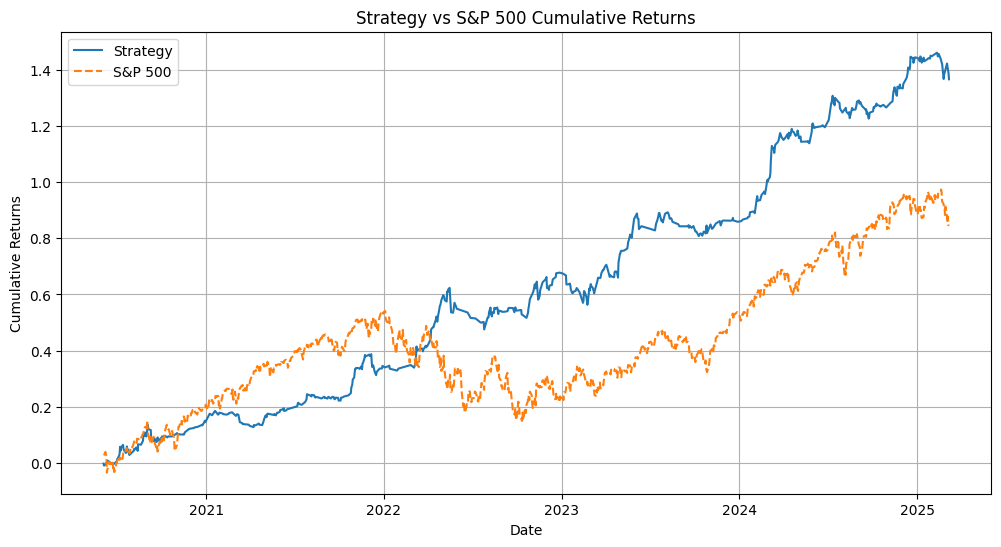

In [11]:
plot_performance(performance)

Collected data for AAPL
Collected data for MSFT
Collected data for AMZN
Collected data for GOOGL
Collected data for META
Collected data for TSLA
Collected data for NVDA
Collected data for JPM
Collected data for JNJ
Collected data for WMT
Collected S&P 500 data


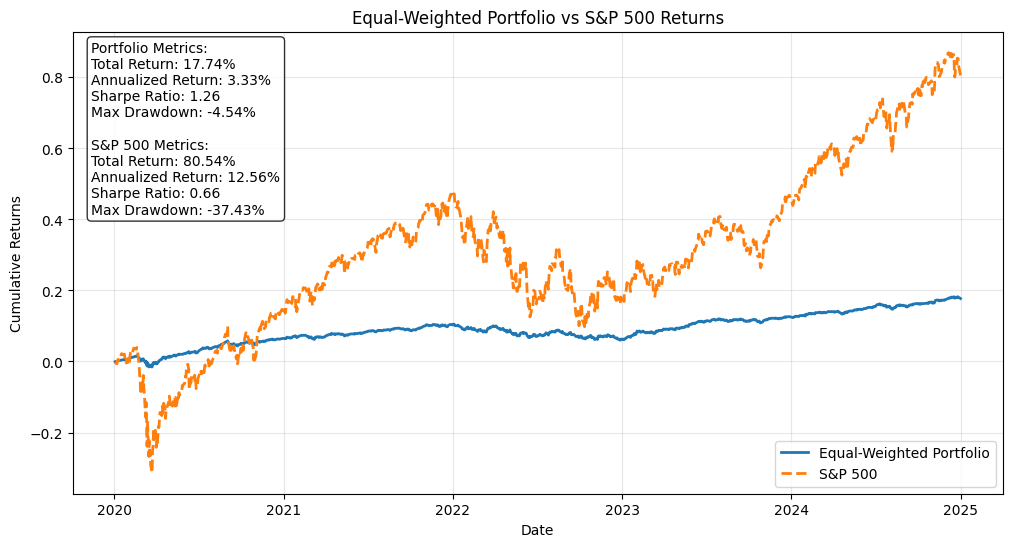

In [12]:
def plot_equal_weighted_returns_with_benchmark():
    start_date='2020-01-01'
    end_date='2025-01-01'

    data_dict={}
    for symbol in symbols:
        try:
            ticker=yf.Ticker(symbol)
            df=ticker.history(start=start_date, end=end_date)
            data_dict[symbol]=df['Close']
            print(f"Collected data for {symbol}")
        except Exception as e:
            print(f"Error collecting data for {symbol}: {str(e)}")

    returns_dict={}
    for symbol, prices in data_dict.items():
        returns_dict[symbol]=prices.pct_change()

    portfolio_returns=pd.DataFrame(returns_dict).mean(axis=1) * 0.1

    try:
        sp500=yf.Ticker('^GSPC')
        sp500_data=sp500.history(start=start_date, end=end_date)
        sp500_returns=sp500_data['Close'].pct_change()
        print("Collected S&P 500 data")
    except Exception as e:
        print(f"Error collecting S&P 500 data: {str(e)}")
        sp500_returns=None

    portfolio_cumulative=(1 + portfolio_returns).cumprod() - 1
    if sp500_returns is not None:
        sp500_cumulative=(1 + sp500_returns).cumprod() - 1

    plt.figure(figsize=(12, 6))

    plt.plot(portfolio_cumulative.index, portfolio_cumulative.values,
             linewidth=2, label='Equal-Weighted Portfolio')

    if sp500_returns is not None:
        plt.plot(sp500_cumulative.index, sp500_cumulative.values,
                 linewidth=2, label='S&P 500', linestyle='--')

    plt.title('Equal-Weighted Portfolio vs S&P 500 Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True, alpha=0.3)
    plt.legend()

    portfolio_total_return=portfolio_cumulative.iloc[-1]
    portfolio_annualized=(1 + portfolio_total_return) ** (252 / len(portfolio_returns)) - 1
    portfolio_sharpe=np.sqrt(252) * portfolio_returns.mean() / portfolio_returns.std()
    portfolio_drawdown=(portfolio_cumulative - portfolio_cumulative.expanding().max()).min()

    metrics_text=f'Portfolio Metrics:\n'
    metrics_text+=f'Total Return: {portfolio_total_return:.2%}\n'
    metrics_text+=f'Annualized Return: {portfolio_annualized:.2%}\n'
    metrics_text+=f'Sharpe Ratio: {portfolio_sharpe:.2f}\n'
    metrics_text+=f'Max Drawdown: {portfolio_drawdown:.2%}'

    if sp500_returns is not None:
        sp500_total_return=sp500_cumulative.iloc[-1]
        sp500_annualized=(1 + sp500_total_return) ** (252 / len(sp500_returns)) - 1
        sp500_sharpe=np.sqrt(252) * sp500_returns.mean() / sp500_returns.std()
        sp500_drawdown=(sp500_cumulative - sp500_cumulative.expanding().max()).min()

        metrics_text+=f'\n\nS&P 500 Metrics:\n'
        metrics_text+=f'Total Return: {sp500_total_return:.2%}\n'
        metrics_text+=f'Annualized Return: {sp500_annualized:.2%}\n'
        metrics_text+=f'Sharpe Ratio: {sp500_sharpe:.2f}\n'
        metrics_text+=f'Max Drawdown: {sp500_drawdown:.2%}'

    plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

plot_equal_weighted_returns_with_benchmark()

In [13]:
def get_asset_allocation_over_time(portfolio) -> pd.DataFrame:
    """
    Calculate and return the asset allocation percentages over time for all assets.

    Returns:
        pd.DataFrame: DataFrame with dates as index and allocation percentages for each asset
    """
    if portfolio is None:
        raise ValueError("Portfolio not constructed. Run construct_portfolio() first.")

    allocation_data = {}

    for date, portfolio_data in portfolio.items():
        positions = portfolio_data['positions']

        date_allocation = {}

        for symbol, weight in positions['long'].items():
            date_allocation[symbol] = weight

        for symbol, weight in positions['short'].items():
            date_allocation[symbol] = -weight

        for symbol in symbols:
            if symbol not in date_allocation:
                date_allocation[symbol] = 0.0

        allocation_data[date] = date_allocation

    allocation_df = pd.DataFrame.from_dict(allocation_data, orient='index')

    allocation_df = allocation_df.sort_index()

    initial_date = signals[symbols[0]].index[0]
    if initial_date not in allocation_df.index:
        initial_row = pd.Series(0.0, index=symbols)
        allocation_df.loc[initial_date] = initial_row
        allocation_df = allocation_df.sort_index()

    return allocation_df

import matplotlib.pyplot as plt

def plot_asset_allocation(portfolio) -> None:
    """
    Plot individual line charts for each asset's allocation over time.
    Positive values indicate long positions, negative values indicate short positions.
    """
    allocation_df = get_asset_allocation_over_time(portfolio)

    num_assets = len(allocation_df.columns)
    figure, axis = plt.subplots(num_assets, 1, figsize=(12, 20), sharex=True)

    for i, symbol in enumerate(allocation_df.columns):
        ax = axis[i]
        ax.plot(allocation_df.index, allocation_df[symbol], label=symbol, linewidth=2)

        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

        ax.set_title(f'Asset Allocation: {symbol}')
        ax.set_ylabel('Portfolio Weight')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

        ax.text(0.02, 0.98, 'Long Positions',
                transform=ax.transAxes,
                verticalalignment='top',
                color='green')
        ax.text(0.02, 0.02, 'Short Positions',
                transform=ax.transAxes,
                verticalalignment='bottom',
                color='red')

    figure.subplots_adjust(hspace=0.5)  subplots

    plt.show()


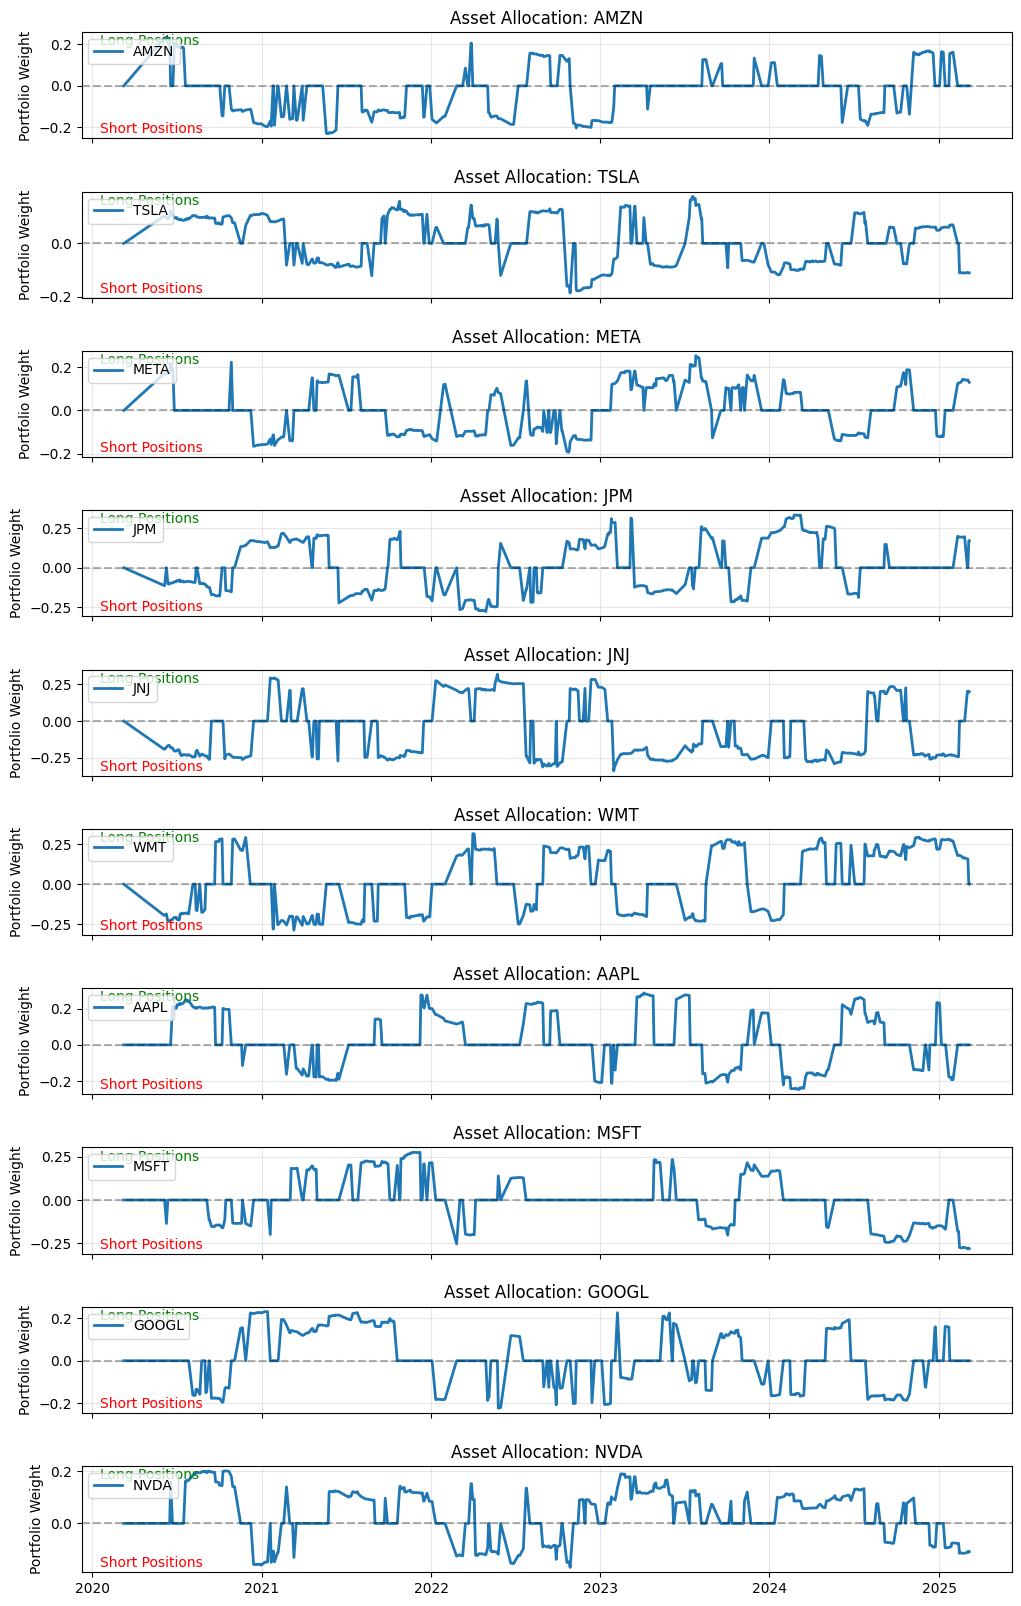

In [15]:

allocation_df = get_asset_allocation_over_time(portfolio)
plot_asset_allocation(portfolio)

In [16]:
def walk_forward_analysis(train_window: int = 756, test_window: int = 252) -> Dict:
    """
    Perform walk-forward analysis to validate the strategy.

    Parameters:
        train_window (int): Number of days in the training window (default: 3 years).
        test_window (int): Number of days in the testing window (default: 1 year).

    Returns:
        Dict: Performance metrics for each testing period.
    """
    if data is None:
        raise ValueError("Data not collected. Run collect_data() first.")

    dates = signals[symbols[0]].index
    n_periods = len(dates)

    results = {
        'start_date': [],
        'end_date': [],
        'cumulative_return': [],
        'sharpe_ratio': [],
        'max_drawdown': [],
        'win_rate': [],
        'profit_factor': []
    }

    for i in range(train_window, n_periods, test_window):
        train_start = dates[i - train_window]
        train_end = dates[i - 1]
        test_start = dates[i]
        test_end = dates[min(i + test_window - 1, n_periods - 1)]

        print(f"\nTraining period: {train_start} to {train_end}")
        print(f"Testing period: {test_start} to {test_end}")

        train_data = {symbol: df[train_start:train_end] for symbol, df in data.items()}
        train_signals = generate_signals(train_data)
        train_portfolio = construct_portfolio(train_signals)

        test_data = {symbol: df[test_start:test_end] for symbol, df in data.items()}
        test_signals = generate_signals(test_data)
        test_portfolio = construct_portfolio(test_signals)

        test_performance, test_transaction_costs, test_portfolio_value = backtest(test_portfolio,test_signals)
        test_metrics = calculate_metrics(test_performance, test_transaction_costs, test_portfolio_value)

        results['start_date'].append(test_start)
        results['end_date'].append(test_end)
        results['cumulative_return'].append(test_metrics['Cumulative Returns'])
        results['sharpe_ratio'].append(test_metrics['Sharpe Ratio'])
        results['max_drawdown'].append(test_metrics['Maximum Drawdown'])
        results['win_rate'].append(test_metrics['Win Rate'])
        results['profit_factor'].append(test_metrics['Profit Factor'])

    return results


def analyze_validation_results(results: Dict, method: str) -> None:
    """
    Analyze and print validation results.

    Parameters:
        results (Dict): Results from walk-forward analysis or cross-validation
        method (str): Name of the validation method used
    """
    print(f"\n{method} Results Summary:")
    print("-" * 80)

    avg_metrics = {
        'Cumulative Return': np.mean(results['cumulative_return']),
        'Sharpe Ratio': np.mean(results['sharpe_ratio']),
        'Max Drawdown': np.mean(results['max_drawdown']),
        'Win Rate': np.mean(results['win_rate']),
        'Profit Factor': np.mean(results['profit_factor'])
    }

    print("\nAverage Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nIndividual Period Results:")
    for i in range(len(results['start_date'])):
        print(f"\nPeriod {i+1}: {results['start_date'][i]} to {results['end_date'][i]}")
        print(f"Cumulative Return: {results['cumulative_return'][i]:.4f}")
        print(f"Sharpe Ratio: {results['sharpe_ratio'][i]:.4f}")
        print(f"Max Drawdown: {results['max_drawdown'][i]:.4f}")
        print(f"Win Rate: {results['win_rate'][i]:.4f}")
        print(f"Profit Factor: {results['profit_factor'][i]:.4f}")

In [17]:
print("\nPerforming Walk-Forward Analysis...")
wf_results = walk_forward_analysis()
analyze_validation_results(wf_results, "Walk-Forward Analysis")



Performing Walk-Forward Analysis...

Training period: 2020-03-09 00:00:00-04:00 to 2023-03-08 00:00:00-05:00
Testing period: 2023-03-09 00:00:00-05:00 to 2024-03-08 00:00:00-05:00

Training period: 2021-03-09 00:00:00-05:00 to 2024-03-08 00:00:00-05:00
Testing period: 2024-03-11 00:00:00-04:00 to 2025-03-07 00:00:00-05:00

Walk-Forward Analysis Results Summary:
--------------------------------------------------------------------------------

Average Metrics:
Cumulative Return: 0.1045
Sharpe Ratio: 1.9516
Max Drawdown: -6.2902
Win Rate: 0.5330
Profit Factor: 1.4456

Individual Period Results:

Period 1: 2023-03-09 00:00:00-05:00 to 2024-03-08 00:00:00-05:00
Cumulative Return: 0.1310
Sharpe Ratio: 2.5051
Max Drawdown: -6.8752
Win Rate: 0.5660
Profit Factor: 1.5899

Period 2: 2024-03-11 00:00:00-04:00 to 2025-03-07 00:00:00-05:00
Cumulative Return: 0.0779
Sharpe Ratio: 1.3982
Max Drawdown: -5.7053
Win Rate: 0.5000
Profit Factor: 1.3013
